# TensorFlow Federated: Differential Privacy

Adapted from TensorFlow docs for the Vector PETs environment.

- [TensorFlow Docs](https://www.tensorflow.org/federated/tutorials/federated_learning_with_differential_privacy)
- [Deep Learning with Differential Privacy](https://arxiv.org/abs/1607.00133)
- [Learning Differentially Private Recurrent Language Models](https://arxiv.org/abs/1710.06963)

Differential Privacy (DP) is a widely used method for bounding and quantifying the privacy leakage of sensitive data when performing learning tasks. Training a model with user-level DP guarantees that the model is unlikely to learn anything significant about the data of any given individual in the dataset, but still allows the model to learn general patterns that exist within the data in its entirety.

In [1]:
# !pip install --quiet --upgrade tensorflow-federated
# !pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

In [2]:
import collections

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp

In [3]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


b'Hello, World!'

# Data

In [13]:
import matplotlib.pyplot as plt
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [11]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

1

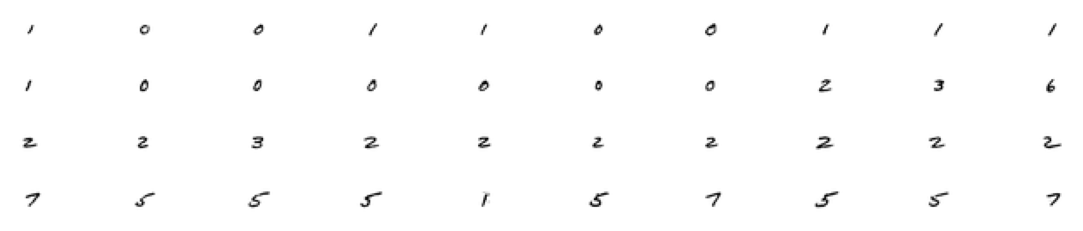

In [14]:
## Example MNIST digits for one client
figure = plt.figure(figsize=(20, 4))
j = 0

for example in example_dataset.take(40):
  plt.subplot(4, 10, j+1)
  plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1

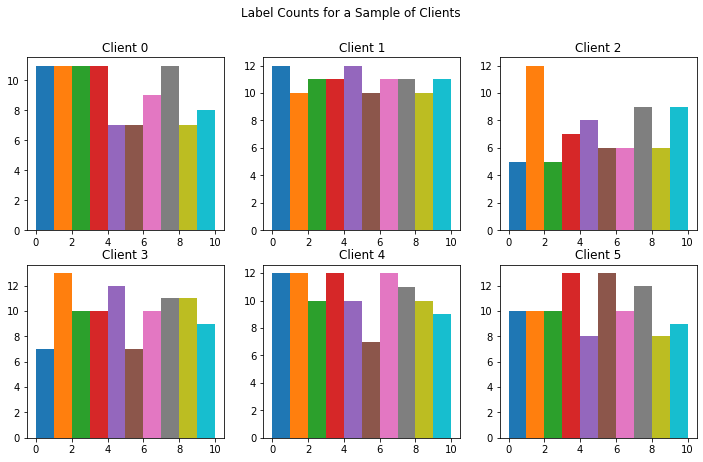

In [15]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i])
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j],
        density=False,
        bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Load and Preprocess EMNIST

In [4]:
def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=True)

  def element_fn(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['pixels'], -1), y=element['label'])

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return (dataset.map(element_fn)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

# Define Model

In [5]:
def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(200, activation=tf.nn.relu),
      tf.keras.layers.Dense(10)])
  return tff.learning.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Federated Averaging + DP

To get user-level DP guarantees, we must change the basic Federated Averaging algorithm in two ways. First, the clients' model updates must be **clipped** before transmission to the server, bounding the maximum influence of any one client. Second, the server must add enough **noise** to the sum of user updates before averaging to obscure the worst-case client influence.

Adding noise will in general degrade the utility of the model, but we can control the amount of noise in the average update at each round.

Our strategy will be to first determine how much noise the model can tolerate with a relatively small number of clients per round with acceptable loss to model utility. 

Then to train the final model, we can increase the amount of noise in the sum, while proportionally scaling up the number of clients per round.

To that end, we first train a series of models with increasing amounts of noise. Specifically, we increase the "noise_multiplier" which is the ratio of the noise standard deviation to the clipping norm. Since we are using adaptive clipping, this means that the actual magnitude of the noise changes from round to round.

In [6]:
# Run five clients per thread. Increase this if your runtime is running out of
# memory. Decrease it if you have the resources and want to speed up execution.
tff.backends.native.set_local_python_execution_context(clients_per_thread=5)

total_clients = len(train_data.client_ids)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  # Using the `dp_aggregator` here turns on differential privacy with adaptive
  # clipping.
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
  sampling_prob = clients_per_round / total_clients

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  # prematurely.
  learning_process = tff.learning.build_federated_averaging_process(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_update_aggregation_factory=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)
    
  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    if round % 5 == 0:
      metrics = eval_process(state.model, [test_data])['eval']
      if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)
    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        train_data.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        train_data.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    # Use selected clients for update.
    state, metrics = learning_process.next(state, sampled_train_data)

  metrics = eval_process(state.model, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame

In [9]:
data_frame = pd.DataFrame()
rounds = 25
clients_per_round = 5

In [7]:
# for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
for noise_multiplier in [0.0, 0.1, 0.2, 0.3, 0.4]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09950529), ('loss', 2.773839)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.13048589), ('loss', 2.2569478)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.23675059), ('loss', 2.1854656)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.14833954), ('loss', 2.1135983)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.3935149), ('loss', 1.9387676)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.42961404), ('loss', 1.7353693)])

Starting training with noise multiplier: 0.1
Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09810933), ('loss', 2.4656541)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.1955574), ('loss', 2.272877)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.09602763), ('loss', 2.193159)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.3237167), ('loss', 2.0285149)])
Round

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

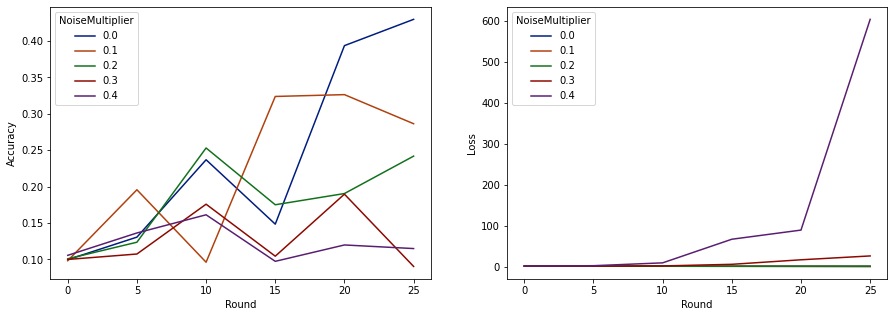

In [9]:
make_plot(data_frame)

# Balancing Quality and Privacy

There is typically a tradeoff between model **quality and privacy**. The higher noise we use, the more privacy we can get for the same amount of training time and number of clients. Conversely, with less noise, we may have a more accurate model, but we'll have to train with more clients per round to reach our target privacy level.

### Choosing Epsilon and Delta

Now we can use tensorflow_privacy functions to determine how many expected clients per round we would need to get acceptable privacy. 

Standard practice is to choose delta somewhat smaller than one over the number of records in the dataset. This dataset has 3383 total training users, We aim for (2, 1e-5)-DP.

We use a simple binary search over the number of clients per round. The tensorflow_privacy function we use to estimate epsilon is based on Wang et al. (2018) and Mironov et al. (2019).

In [10]:
rdp_orders = ([1.25, 1.5, 1.75, 2., 2.25, 2.5, 3., 3.5, 4., 4.5] +
              list(range(5, 64)) + [128, 256, 512])

total_clients = 3383
base_noise_multiplier = 0.5
base_clients_per_round = 50
target_delta = 1e-5
target_eps = 2

def get_epsilon(clients_per_round):
  # If we use this number of clients per round and proportionally
  # scale up the noise multiplier, what epsilon do we achieve?
  q = clients_per_round / total_clients
  noise_multiplier = base_noise_multiplier
  noise_multiplier *= clients_per_round / base_clients_per_round
  rdp = tfp.compute_rdp(
      q, noise_multiplier=noise_multiplier, steps=rounds, orders=rdp_orders)
  eps, _, _ = tfp.get_privacy_spent(rdp_orders, rdp, target_delta=target_delta)
  return clients_per_round, eps, noise_multiplier

def find_needed_clients_per_round():
  hi = get_epsilon(base_clients_per_round)
  if hi[1] < target_eps:
    return hi

  # Grow interval exponentially until target_eps is exceeded.
  while True:
    lo = hi
    hi = get_epsilon(2 * lo[0])
    if hi[1] < target_eps:
      break

  # Binary search.
  while hi[0] - lo[0] > 1:
    mid = get_epsilon((lo[0] + hi[0]) // 2)
    if mid[1] > target_eps:
      lo = mid
    else:
      hi = mid

  return hi

clients_per_round, _, noise_multiplier = find_needed_clients_per_round()
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

To get (2, 1e-05)-DP, use 97 clients with noise multiplier 0.97.


Now we can train our final private model based on the suggested clients and noise multiplier.

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.10330133), ('loss', 2.5248725)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.25318378), ('loss', 2.2267268)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.14672315), ('loss', 2.1328006)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.45393318), ('loss', 1.9464718)])


2022-08-24 16:17:12.074420: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Round  20: OrderedDict([('sparse_categorical_accuracy', 0.5973256), ('loss', 1.7185669)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.64887834), ('loss', 1.474156)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.763029), ('loss', 0.79324645)])
Round  75: OrderedDict([('sparse_categorical_accuracy', 0.7836501), ('loss', 0.68955517)])
Round 100: OrderedDict([('sparse_categorical_accuracy', 0.81205916), ('loss', 0.60071594)])


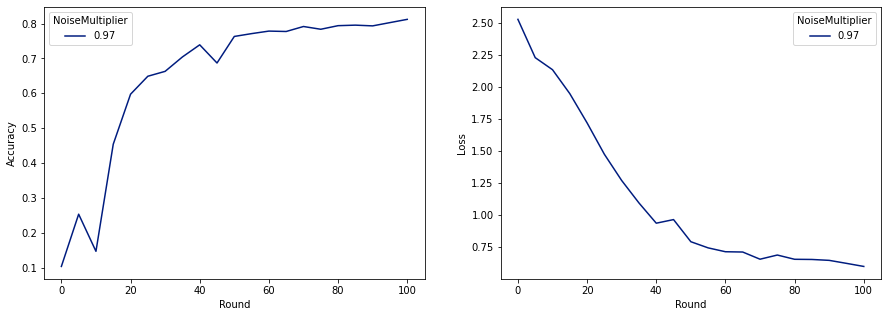

In [11]:
rounds = 100
noise_multiplier = 0.97
clients_per_round = 97

data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)

make_plot(data_frame)